In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

c:\Users\thoma\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def computeLocalPUDensity(all_events_vertex_xs, delta_x):
    localPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        localPUdensity.append((np.sum(np.abs(vertex_xs[0]-vertex_xs[1:]) < delta_x))/(2*delta_x))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_xs, mu=200, sigma_x=50):
    avgPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        avgPUdensity.append(mu/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_xs[0]**2/sigma_x**2))
    return avgPUdensity
def abs_event_to_specific_ntuple_event(abs_event, files):
    n_events_loaded = 0
    for file in files:
        root_file = uproot.open(file)
        for key in root_file.keys():
            if key.startswith('EventTree'):
                tree = root_file[key]
                n_events_in_tree = len(tree['track_t'].array(library='np'))
                if n_events_loaded+n_events_in_tree > abs_event:
                    return file, key, abs_event-n_events_loaded
                n_events_loaded += n_events_in_tree

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(3, 4)]
track_z0 = np.array([], dtype='object')
track_z0_var = np.array([], dtype='object') 
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

# reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')
track_qOverP = np.array([], dtype='object') 
track_theta = np.array([], dtype='object')
for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            # reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))
            
            track_qOverP = np.concatenate((track_qOverP, tree['track_qOverP'].array(library='np')))
            track_theta = np.concatenate((track_theta, tree['track_theta'].array(library='np')))

track_pT = np.abs(np.array([np.sin(theta) for theta in track_theta], dtype='object')/track_qOverP)
print(len(track_t), ' events loaded')

932  events loaded


In [4]:
# return cluster times and track idxs in these clusters
def basic_time_clustering1(vertex_track_ts, max_delta_t):
    vertex_track_ts_left = vertex_track_ts[:]
    vertex_track_idx_left = np.arange(len(vertex_track_ts))

    curr_cluster_track_ts = vertex_track_ts[:]
    curr_cluster_track_idx = np.arange(len(vertex_track_ts))

    clusters_track_t = []
    clusters_idx = []

    converged = False
    iterations = 0
    while not converged:
        if (len(vertex_track_ts_left) == 1 and len(curr_cluster_track_ts) == 1):
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            break
        vtx_t = np.median(curr_cluster_track_ts)
        
        inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= max_delta_t
        inside_t = curr_cluster_track_ts[inside_t_local_idx]

        # no tracks in current cluster outside x sigma
        if len(inside_t) == len(curr_cluster_track_ts):
            iterations = 0
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            # remove tracks from pool

            tracks_to_keep_local_idx = np.where(np.isin(vertex_track_idx_left, curr_cluster_track_idx, invert=True))
            vertex_track_ts_left = vertex_track_ts_left[tracks_to_keep_local_idx]
            vertex_track_idx_left = vertex_track_idx_left[tracks_to_keep_local_idx]
            
            curr_cluster_track_ts = vertex_track_ts_left
            curr_cluster_track_idx = vertex_track_idx_left
            
            if len(vertex_track_idx_left) == 0:
                converged = True
        # do sigma cut
        else:
            curr_cluster_track_ts = curr_cluster_track_ts[inside_t_local_idx]
            curr_cluster_track_idx = curr_cluster_track_idx[inside_t_local_idx]
            if len(curr_cluster_track_ts) == 0:
                curr_cluster_track_ts = vertex_track_ts_left
                curr_cluster_track_idx = vertex_track_idx_left
        iterations += 1
        if iterations > 1e4:
            print('CLUSTERING FAILED')
            return (), ()
    return clusters_track_t, clusters_idx

def basic_time_clustering2(vertex_track_ts, n_sigma, maxIter, max_sigma_t):
    vertex_track_ts_left = vertex_track_ts[:]
    vertex_track_idx_left = np.arange(len(vertex_track_ts))

    curr_cluster_track_ts = vertex_track_ts[:]
    curr_cluster_track_idx = np.arange(len(vertex_track_ts))

    clusters_track_t = []
    clusters_idx = []

    converged = False
    iterations = 0
    while not converged:
        if (len(vertex_track_ts_left) == 1 and len(curr_cluster_track_ts) == 1):
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            break
        vtx_t = np.median(curr_cluster_track_ts)
        vtx_t_sigma = np.std(curr_cluster_track_ts, ddof=1)
        vtx_t_sigma = np.min((vtx_t_sigma, max_sigma_t))

        inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= vtx_t_sigma*n_sigma
        inside_t = curr_cluster_track_ts[inside_t_local_idx]

        # no tracks in current cluster outside x sigma
        if len(inside_t) == len(curr_cluster_track_ts):
            iterations = 0
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            # remove tracks from pool

            tracks_to_keep_local_idx = np.where(np.isin(vertex_track_idx_left, curr_cluster_track_idx, invert=True))
            vertex_track_ts_left = vertex_track_ts_left[tracks_to_keep_local_idx]
            vertex_track_idx_left = vertex_track_idx_left[tracks_to_keep_local_idx]
            
            curr_cluster_track_ts = vertex_track_ts_left
            curr_cluster_track_idx = vertex_track_idx_left
            
            if len(vertex_track_idx_left) == 0:
                converged = True
        # do sigma cut
        else:
            iterations += 1
            curr_cluster_track_ts = curr_cluster_track_ts[inside_t_local_idx]
            curr_cluster_track_idx = curr_cluster_track_idx[inside_t_local_idx]
            if len(curr_cluster_track_ts) == 0:
                curr_cluster_track_ts = vertex_track_ts_left
                curr_cluster_track_idx = vertex_track_idx_left

        if iterations > maxIter:
            print('maxIter hit')
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            # remove tracks from pool

            tracks_to_keep_local_idx = np.where(np.isin(vertex_track_idx_left, curr_cluster_track_idx, invert=True))
            vertex_track_ts_left = vertex_track_ts_left[tracks_to_keep_local_idx]
            vertex_track_idx_left = vertex_track_idx_left[tracks_to_keep_local_idx]
            
            curr_cluster_track_ts = vertex_track_ts_left
            curr_cluster_track_idx = vertex_track_idx_left
            
            if len(vertex_track_idx_left) == 0:
                converged = True
            
    return clusters_track_t, clusters_idx
     

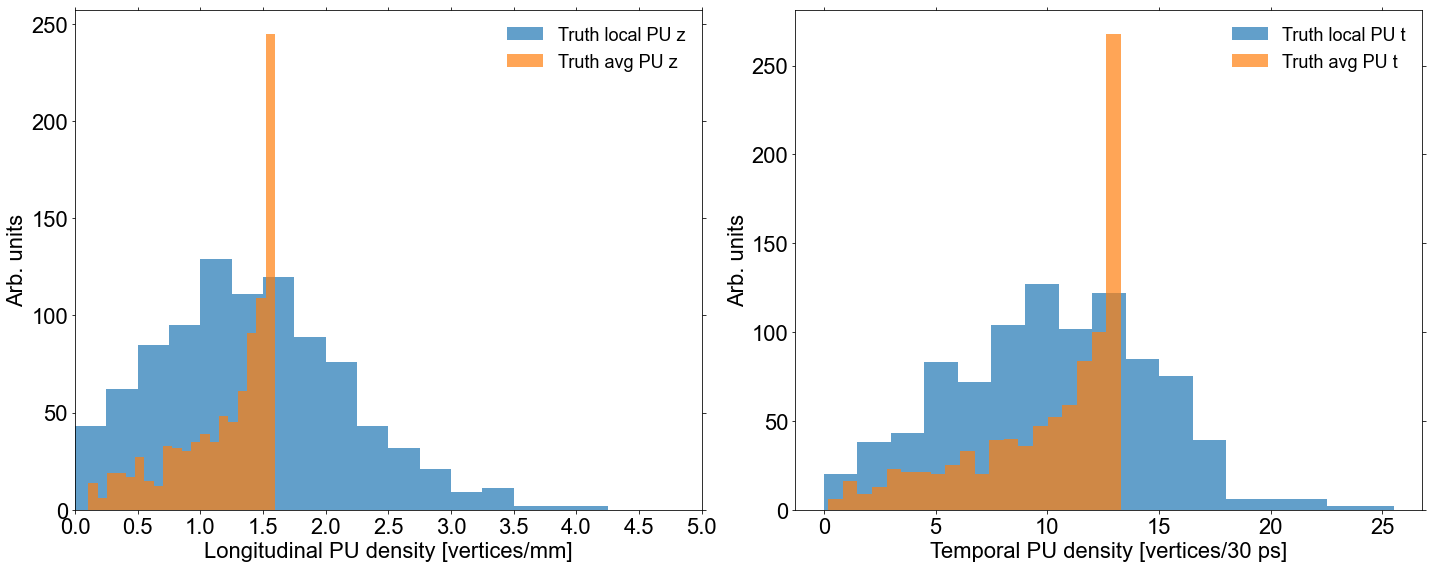

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

delta_z = 2
truth_localzPU = computeLocalPUDensity(truth_vertex_z, delta_z)
truth_avgzPU = computeAvgPUDensity(truth_vertex_z, mu=200, sigma_x=50)


zbinwidth = 1/(2*delta_z)
_, zLPU_truth_bin_edges, _ = ax1.hist(truth_localzPU, bins=np.arange(np.min(truth_localzPU), np.max(truth_localzPU) + zbinwidth, zbinwidth), density=False, alpha=0.7, label='Truth local PU z')
_, zAPU_truth_bin_edges, _ = ax1.hist(truth_avgzPU, bins=20, density=False, alpha=0.7, label='Truth avg PU z')

ax1.set_xlabel('Longitudinal PU density [vertices/mm]')
ax1.set_ylabel('Arb. units')
# ax1.set_yscale('log')
ax1.set_xticks(np.arange(0, 10, 0.5))
ax1.set_xlim(0, 5)
ax1.legend(frameon=False)


sigma_t = 180
delta_t = 20

tPU_unit = 30
truth_localtPU = computeLocalPUDensity(1e3*truth_vertex_t/tPU_unit, delta_t/tPU_unit)
truth_avgtPU = computeAvgPUDensity(1e3*truth_vertex_t/tPU_unit, mu=200, sigma_x=sigma_t/tPU_unit)

tbinwidth = 1/(2*delta_t/tPU_unit) * 2
_, tLPU_truth_bin_edges, _ = ax2.hist(truth_localtPU, bins=np.arange(np.min(truth_localtPU), np.max(truth_localtPU) + tbinwidth, tbinwidth), density=False, alpha=0.7, label='Truth local PU t', color='C0')
_, tAPU_truth_bin_edges, _ = ax2.hist(truth_avgtPU, bins=20, density=False, alpha=0.7, label='Truth avg PU t', color='C1')

ax2.set_xlabel('Temporal PU density [vertices/{} ps]'.format(tPU_unit))
ax2.set_ylabel('Arb. units')
# ax2.set_yscale('log')
# ax2.set_xticks(np.arange(0, 0.5, 0.1))
# ax2.set_xlim(0, 0.5)
ax2.legend(frameon=False)
fig.tight_layout()

In [6]:
events_in_zLPU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_zLPU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))
events_in_tLPU_bins = []
for bin in tLPU_truth_bin_edges:
    events_in_tLPU_bins.append(np.argwhere(np.isclose(truth_localtPU, bin)))

events_in_zAPU_bins = []
for i, bin in enumerate(zAPU_truth_bin_edges[1:]):
    events_in_zAPU_bins.append(np.argwhere(np.logical_and(truth_avgzPU > zAPU_truth_bin_edges[i-1], truth_avgzPU < bin)))
events_in_tAPU_bins = []
for i, bin in enumerate(tAPU_truth_bin_edges[1:]):
    events_in_tAPU_bins.append(np.argwhere(np.logical_and(truth_avgtPU > tAPU_truth_bin_edges[i-1], truth_avgtPU < bin)))

In [7]:
## Find truth reco link via number of shared tracks
delta_z_link_cut = 0.5

truthHS_to_reco_link_idx = []
truthHS_to_reco_link_n_shared_tracks = []

truthHS_to_reco_delta_z_cut_link_idx = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight = []

truthHS_to_reco_link_idx_req_HS = []
truthHS_to_reco_link_n_shared_tracks_req_HS = []

truthHS_to_reco_link_idx_req_clean = []
truthHS_to_reco_link_n_shared_tracks_req_clean = []

truthHS_to_reco_link_idx_req_cleanHS = []
truthHS_to_reco_link_n_shared_tracks_req_cleanHS = []

for event_idx in range(len(truth_vertex_t)):
    event_truth_to_reco_idx = -1
    event_truth_to_reco_n_tracks = -1

    event_truth_to_reco_delta_z_cut_idx = -1
    event_truth_to_reco_delta_z_cut_n_tracks = -1
    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = -1

    event_truth_to_reco_idx_req_clean = -1
    event_truth_to_reco_n_tracks_req_clean = -1

    event_truth_to_reco_idx_req_cleanHS = -1
    event_truth_to_reco_n_tracks_req_cleanHS = -1

    event_truth_to_reco_n_tracks_req_HS = -1
    event_truth_to_reco_idx_req_HS = -1

    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        if i < 100:
            intersecting_tracks, _, reco_shared_tracks_idxs = np.intersect1d(truth_hs_track_idx, reco_track_idxs, return_indices=True)
            n = len(intersecting_tracks)
            # print(n)
            if n > event_truth_to_reco_n_tracks:
                event_reco_total_weight = np.sum(reco_vertex_track_weights[event_idx][i])
                event_reco_shared_Weight = np.sum(reco_vertex_track_weights[event_idx][i][reco_shared_tracks_idxs])

                event_truth_to_reco_idx = i
                event_truth_to_reco_n_tracks = n
                if np.abs(truth_vertex_z[event_idx][0] - reco_vertex_z[event_idx][i]) < delta_z_link_cut:
                    event_truth_to_reco_delta_z_cut_idx = i
                    event_truth_to_reco_delta_z_cut_n_tracks = n
                    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = event_reco_shared_Weight/event_reco_total_weight
    
    ## Require reco HS
    if event_truth_to_reco_delta_z_cut_idx == 0:
        event_truth_to_reco_idx_req_HS = 0
        event_truth_to_reco_n_tracks_req_HS = event_truth_to_reco_delta_z_cut_n_tracks
    
    if event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight > 0.7:
        event_truth_to_reco_idx_req_clean = event_truth_to_reco_delta_z_cut_idx
        event_truth_to_reco_n_tracks_req_clean = event_truth_to_reco_delta_z_cut_n_tracks
        if event_truth_to_reco_delta_z_cut_idx == 0:
            event_truth_to_reco_idx_req_cleanHS = 0
            event_truth_to_reco_n_tracks_req_cleanHS = event_truth_to_reco_delta_z_cut_n_tracks


    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
    truthHS_to_reco_link_n_shared_tracks.append(event_truth_to_reco_n_tracks)    
    
    truthHS_to_reco_delta_z_cut_link_idx.append(event_truth_to_reco_delta_z_cut_idx)
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks.append(event_truth_to_reco_delta_z_cut_n_tracks)    
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight.append(event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight)    
    
    truthHS_to_reco_link_idx_req_HS.append(event_truth_to_reco_idx_req_HS)
    truthHS_to_reco_link_n_shared_tracks_req_HS.append(event_truth_to_reco_n_tracks_req_HS)

    truthHS_to_reco_link_idx_req_clean.append(event_truth_to_reco_idx_req_clean)
    truthHS_to_reco_link_n_shared_tracks_req_clean.append(event_truth_to_reco_n_tracks_req_clean)

    truthHS_to_reco_link_idx_req_cleanHS.append(event_truth_to_reco_idx_req_cleanHS)
    truthHS_to_reco_link_n_shared_tracks_req_cleanHS.append(event_truth_to_reco_n_tracks_req_cleanHS)

truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)
truthHS_to_reco_link_idx_req_HS = np.array(truthHS_to_reco_link_idx_req_HS)
truthHS_to_reco_delta_z_cut_link_idx = np.array(truthHS_to_reco_delta_z_cut_link_idx)
truthHS_to_reco_link_idx_req_clean = np.array(truthHS_to_reco_link_idx_req_clean)
truthHS_to_reco_link_idx_req_cleanHS = np.array(truthHS_to_reco_link_idx_req_cleanHS)

reco_idx 0
tLPU 0.0
zLPU 1.75


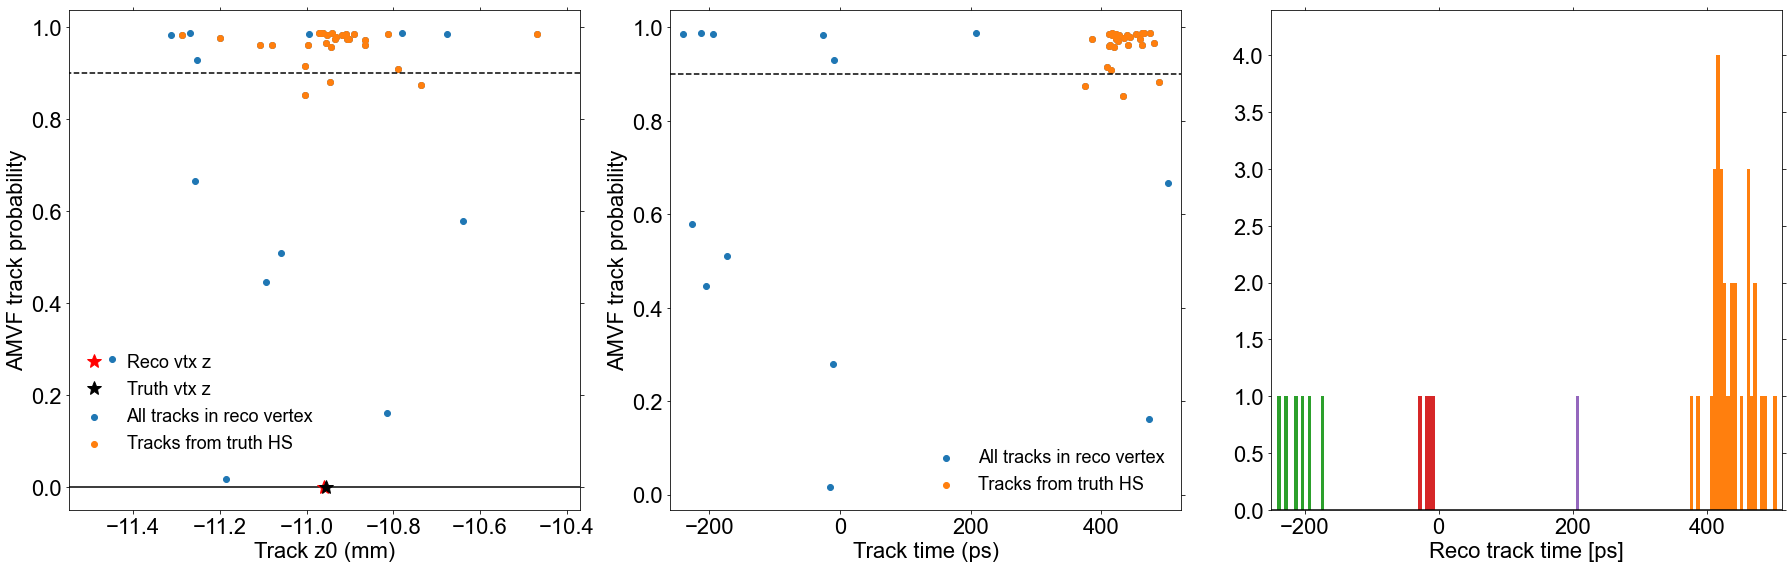

In [53]:
pu_bin = 0
event_idx = events_in_tLPU_bins[pu_bin][5]
event_idx = event_idx[0]
truth_idx = 0
reco_idx = truthHS_to_reco_link_idx_req_cleanHS[event_idx]
print('reco_idx', reco_idx)

print('tLPU', truth_localtPU[event_idx])
print('zLPU', truth_localzPU[event_idx])

reco_track_idxs = reco_vertex_track_idxs[event_idx][reco_idx]
truth_track_idxs = truth_vertex_track_idxs[event_idx][truth_idx]
shared_tracks_idx, shared_tracks_local_reco_idxs, _ = np.intersect1d(reco_track_idxs, truth_track_idxs, return_indices=True)
times = track_t30[event_idx][reco_track_idxs]
times_clean_idx = np.logical_and(times != -1e3, times != -1e6)
times = times[times_clean_idx]
z0s = track_z0[event_idx][reco_track_idxs][times_clean_idx]
track_weights = reco_vertex_track_weights[event_idx][reco_idx][times_clean_idx]

cluster_t, cluster_idx = basic_time_clustering2(times, 3, maxIter=100, max_sigma_t=50e-3)

fig, (ax3, ax2, ax1) = plt.subplots(1, 3)
fig.set_size_inches(25, 8)

bins = np.arange(1e3*np.min(times)-5, 1e3*np.max(times)+5, 5)
hist = ax1.hist(1e3*times, bins=bins)
ax1.plot(np.mean(1e3*times), -0.2, 'ro', ms=7, label='No clustering')
ax1.plot(np.average(1e3*times, weights=track_weights), -0.4, 'rs', ms=7)

# ax1.text(1e3*np.min(times) - 10*np.sign(np.min(times)), np.max(hist[0])-0.2, 'RMS (ps): {:.1f}'.format(1e3*np.sqrt(np.mean((times-truth_vertex_t[event_idx][truth_idx])**2))), fontsize=22)

for i, (ts, idxs) in enumerate(zip(cluster_t, cluster_idx)):
    cluster_hist = ax1.hist(1e3*np.array(ts), bins=bins)
    ax1.plot(np.mean(1e3*np.array(ts)), -0.2, 'o', c='C{}'.format(i+1), ms=10)
    ax1.plot(np.average(1e3*np.array(times[idxs]), weights=track_weights[idxs]), -0.4, 's', c='C{}'.format(i+1), ms=10)
    # if len(ts) > 1:
    #     ax1.text(np.mean(1e3*np.array(ts))-20, np.max(cluster_hist[0])+0.1, '{:.1f}'.format(np.std(1e3*ts, ddof=1)), fontsize=22)
    # ax2.plot(np.mean(1e3*np.array(ts)), 0, 'o', c='C{}'.format(i+1), ms=10)

ax1.plot(1e3*truth_vertex_t[event_idx][truth_idx], -0.6, 'ko', ms=9, label='Truth vtx t')
ax1.hlines(0, 1e3*np.min(times)-10, 1e3*np.max(times)+10)
ax1.set_xlim(1e3*np.min(times)-10, 1e3*np.max(times)+10)
ax1.set_ylim(0, np.max(hist[0])+0.4)
ax1.set_xlabel('Reco track time [ps]')
# ax1.legend(frameon=False)

_ = ax2.scatter(1e3*times, track_weights, label='All tracks in reco vertex')
_ = ax2.scatter(1e3*track_t30[event_idx][shared_tracks_idx], reco_vertex_track_weights[event_idx][reco_idx][shared_tracks_local_reco_idxs], label='Tracks from truth HS')

# ax2.hlines(0, 1e3*np.min(times)-20, 1e3*np.max(times)+20)
ax2.hlines(0.9, 1e3*np.min(times)-20, 1e3*np.max(times)+20, ls='--')
ax2.set_xlim(1e3*np.min(times)-20, 1e3*np.max(times)+20)
# ax2.plot(1e3*truth_vertex_t[event_idx][truth_idx], 0, 'k*', ms=15)

ax2.set_xlabel('Track time (ps)')
ax2.set_ylabel('AMVF track probability')
ax2.legend(frameon=False)

_ = ax3.scatter(z0s, track_weights, label='All tracks in reco vertex')
_ = ax3.scatter(track_z0[event_idx][shared_tracks_idx], reco_vertex_track_weights[event_idx][reco_idx][shared_tracks_local_reco_idxs], label='Tracks from truth HS')
ax3.hlines(0, np.min(z0s)-0.2, np.max(z0s)+0.2)
ax3.hlines(0.9, np.min(z0s)-0.2, np.max(z0s)+0.2, ls='--')
ax3.set_xlim(np.min(z0s)-0.1, np.max(z0s)+0.1)
# for truth_z in truth_vertex_z[event_idx][1:]:
#     ax3.plot(truth_z, 0, 'ko', ms=10)
ax3.plot(reco_vertex_z[event_idx][truth_idx], 0, 'r*', ms=15, label='Reco vtx z')
ax3.plot(truth_vertex_z[event_idx][truth_idx], 0, 'k*', ms=15, label='Truth vtx z')
ax3.set_xlabel('Track z0 (mm)')
ax3.set_ylabel('AMVF track probability')
ax3.legend(frameon=False, loc=(0, 0.1))


fig.tight_layout()

In [9]:
shared_tracks_idx, shared_tracks_local_reco_idxs, _ = np.intersect1d(reco_track_idxs, truth_track_idxs, return_indices=True)

In [10]:
track_t30[event_idx][truth_track_idxs]

array([0.5449987 , 0.56037474, 0.5255639 , 0.5155892 , 0.50528914,
       0.51875526, 0.52378976, 0.5035049 , 0.5279792 , 0.51560265,
       0.58558476, 0.5385522 , 0.51129365, 0.48710033, 0.55854225,
       0.5271849 , 0.5620745 , 0.4805334 , 0.57349324, 0.5735979 ,
       0.5385349 , 0.55306834, 0.51425683, 0.54268026, 0.47563612,
       0.5129753 , 0.5111858 , 0.5116911 , 0.54509217, 0.55705124,
       0.53932875, 0.5138057 , 0.55550283, 0.5588895 , 0.48985794,
       0.54086816, 0.5300669 , 0.5200469 , 0.50631505, 0.5433956 ,
       0.5009442 , 0.55068314, 0.50172573, 0.53330857, 0.54857814,
       0.5418716 , 0.5304131 , 0.48898423, 0.5550515 , 0.5601822 ,
       0.5293254 , 0.5229148 , 0.5399884 , 0.5901982 , 0.5434225 ,
       0.5227502 , 0.46979123, 0.5676729 , 0.5275124 , 0.54887813,
       0.49006727], dtype=float32)